# Explaining Model Decisions and Performance

## Overview

At a very high level, Howso Engine is about: 

- Making an accurate prediction (even with limited or sparse data!) 

- Explaining the prediction process 

- Showing key properties of the data 

In this notebook, we will be using the adult data set as an example to demonstrate some of Howso Engine’s capabilities, including cases and features which contribute to predictions, anomalies analysis, and potential improvements to the data to gain more insight into the data.  


In [1]:
import os

import pandas as pd
import plotly.io as pio
from pmlb import fetch_data

from howso import engine
from howso.utilities import infer_feature_attributes
from howso.visuals import (
    plot_anomalies,
    plot_dataset,
    plot_feature_importances,
)

pio.renderers.default = os.getenv("HOWSO_RECIPE_RENDERER", "notebook")

# Section 1: Train and Configure the Trainee

## Step 1: Load Data

We are using the Adult dataset in this recipe.

In [2]:
# Load adult data
df = fetch_data('adult', local_cache_dir="../../../data/adult")

# Specify column names
df.columns = ['age', 'workclass', 'fnlwgt', 'education',
              'education-num', 'marital-status', 'occupation',
              'relationship', 'race', 'sex', 'capital-gain',
              'capital-loss', 'hours-per-week', 'native-country', 'target']

# Sample the data for demo purpose
df = df.sample(1_000).reset_index(drop=True)

df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,33.0,4,191930.0,11,9.0,4,8,2,2,1,0.0,0.0,50.0,39,1
1,54.0,6,164757.0,8,11.0,2,3,0,4,1,0.0,0.0,16.0,39,1
2,46.0,2,14878.0,14,15.0,2,10,0,1,1,0.0,0.0,40.0,30,0
3,34.0,4,46492.0,11,9.0,2,3,0,4,1,0.0,0.0,50.0,39,0
4,65.0,6,111483.0,15,10.0,2,4,0,4,1,0.0,2174.0,10.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33.0,4,157887.0,6,5.0,2,7,0,4,1,0.0,0.0,50.0,39,1
996,20.0,4,38001.0,15,10.0,4,8,3,4,0,0.0,0.0,20.0,39,1
997,41.0,4,31221.0,11,9.0,0,8,4,4,0,0.0,0.0,30.0,39,1
998,57.0,4,296152.0,15,10.0,0,4,2,4,0,594.0,0.0,10.0,39,1


## Step 2: Define the Feature Attributes

For all Howso Engine usage, we must define feature attributes. We will also define our action and context features.

In [3]:
partial_features = {
    "education": {"type": "nominal"}
}

# Infer features attributes
features = infer_feature_attributes(df, features=partial_features)

# Specify the context and action feature
action_features = ['target']
context_features = features.get_names(without=['target'])

## Step 3: Create the Trainee, Train, and Analyze

In [4]:
# Create the trainee with custom name
t = engine.Trainee(name='Engine - Predictions and Explanations Recipe', features=features, overwrite_existing=True)

# Train
t.train(df)

# Analyze the model
t.analyze(action_features=action_features, context_features=features.get_names(without=action_features))


Version 37.1.1 of Howso Engine™ is available. You are using version 36.4.0.


## Step 4: Evaluate Trainee Accuracy

In [5]:
accuracy = t.get_prediction_stats(
    action_feature=action_features[0],
    details = {
        "prediction_stats": True,
        "selected_prediction_stats": ["accuracy"]
        }
)['target'].iloc[0]

print("Test set prediction accuracy: {acc}".format(acc=accuracy))

Test set prediction accuracy: 0.828


# Section 2: Explain Predictions

How were the predictions made? 

Howso Engine provides detailed explanation for complete model transparency. Let's examine a subset of the explanations.


## Step 1: Inspect Feature Importance (Global)

Feature importance information provides insight into the features which are primary drivers for each prediction. This is important to understand in the context of AI bias and discrimination (ex. Sensitive attribute being the primary contribution to a prediction). 

This information is available at the global level (overall model), but can also be computed at the local level (regional model for each case).

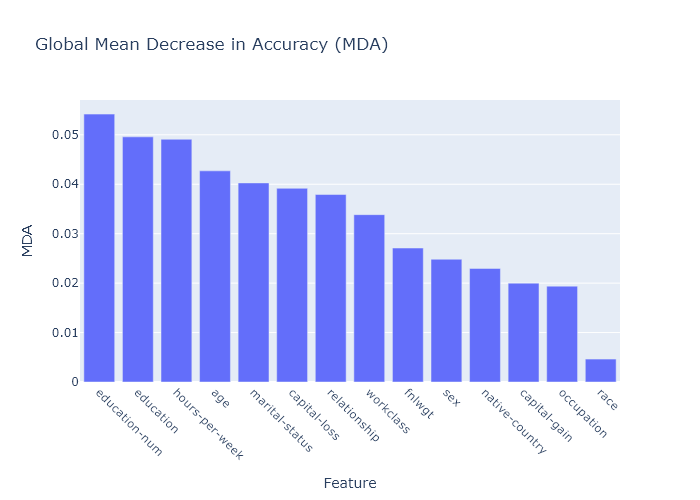

In [6]:
global_mda = t.get_prediction_stats(
    action_feature=action_features[0],
    details = {"feature_robust_accuracy_contributions": True}
)
plot_feature_importances(global_mda, title="Global Mean Decrease in Accuracy (MDA)", yaxis_title="MDA")

MDA values for each feature indicate to the user which features have the most significant individual predictive power. Those with higher values are more important for the model's predictions. Furthermore, features with negative MDA values can even be considered detrimental to model accuracy. However, it's important to note that these are global values and features with negative MDA values could still be beneficial for model accuracy in some regions of the data.

## Step 2: Feature Uncertainty (Global)

Are there any noisy features? 

Howso Engine’s performance is robust against noisy feature[s], and can maintain a high level of accuracy despite noisy data. 

Part of the reason Howso Engine can maintain its level of performance despite noisy data is through the characterization of feature uncertainties (residuals). The feature residuals can be extracted for user review. 

> Note: Feature Residuals are in the same units as the original features which makes it easy to interpret. For example, the residual for the “age” feature has the unit of years as in the original data.

Feature residuals are available at the global level (overall model) and at the local level (regional model for each case).


In [7]:
global_feature_residuals = t.get_prediction_stats(
    action_feature=action_features[0],
    details = {
        "prediction_stats": True,
        "selected_prediction_stats": ["mae"]
    }
)
global_feature_residuals = global_feature_residuals.T.rename(columns={'mae':'residuals'}).sort_values('residuals', ascending=False)

global_feature_residuals.iloc[0:10]

,residuals
fnlwgt,81959.906944
capital-gain,1591.439985
capital-loss,147.508730
age,10.752312
hours-per-week,9.111811
native-country,3.536651
education-num,1.723021
occupation,0.871114
relationship,0.498900
education,0.492631


# Section 3: Inspect the Data for Anomalies

Howso Engine can be used to show interesting information pertaining to the data and model, such as anomalous cases and potential model improvements. 
 
For each prediction, Howso Engine can also extract the influential cases and boundary cases to provide an exact explanation to the prediction process. More details on what’s available can be found in the notebook “2-interpretability.ipynb”.


## Step 1: Identify Anomalous cases

Anomalous cases can exist in the data as either an outlier or inlier. Outliers are cases which are very different than other cases. Inliers are cases which are too similar to other cases and do not follow the expected distribution. An inlier could be a fraudulent case that is “too good to be true”. 



In [8]:
# Store the familiarity conviction into each case with `react_into_features`,
# this will be used to identify anomalous cases
t.analyze()
t.react_into_features(familiarity_conviction_addition=True, distance_contribution=True)
stored_convictions = t.get_cases(session=t.active_session, features=df.columns.tolist() + ['familiarity_conviction_addition','.session_training_index', '.session', 'distance_contribution'])

stored_convictions

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution
0,33.0,4,191930.0,11,9.0,4,8,2,2,1,0.0,0.0,50.0,39,1,2.358593,0,5c430afe-9f5f-477a-b3dc-327fc000553d,5.338776
1,54.0,6,164757.0,8,11.0,2,3,0,4,1,0.0,0.0,16.0,39,1,47.549545,1,5c430afe-9f5f-477a-b3dc-327fc000553d,10.887711
2,46.0,2,14878.0,14,15.0,2,10,0,1,1,0.0,0.0,40.0,30,0,0.492163,2,5c430afe-9f5f-477a-b3dc-327fc000553d,48.883560
3,34.0,4,46492.0,11,9.0,2,3,0,4,1,0.0,0.0,50.0,39,0,0.514951,3,5c430afe-9f5f-477a-b3dc-327fc000553d,1.508737
4,65.0,6,111483.0,15,10.0,2,4,0,4,1,0.0,2174.0,10.0,39,0,0.406447,4,5c430afe-9f5f-477a-b3dc-327fc000553d,40.461772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33.0,4,157887.0,6,5.0,2,7,0,4,1,0.0,0.0,50.0,39,1,0.430000,995,5c430afe-9f5f-477a-b3dc-327fc000553d,2.264959
996,20.0,4,38001.0,15,10.0,4,8,3,4,0,0.0,0.0,20.0,39,1,0.470838,996,5c430afe-9f5f-477a-b3dc-327fc000553d,1.162228
997,41.0,4,31221.0,11,9.0,0,8,4,4,0,0.0,0.0,30.0,39,1,1.020223,997,5c430afe-9f5f-477a-b3dc-327fc000553d,3.008712
998,57.0,4,296152.0,15,10.0,0,4,2,4,0,594.0,0.0,10.0,39,1,7.888693,998,5c430afe-9f5f-477a-b3dc-327fc000553d,19.305138


Here we set a threshold for familarity conviction that can be used to identify cases as anomalies. In the case of this notebook, we use a threshold of 0.50. Cases with a conviction value below this threshold will be deemed anomalous. Then we split up these anomalies by the mean distance contribution with those lower distance contributions being inliers and those with larger distance contributions being outliers.

In [9]:
# Threshold to determine which cases will be deemed anomalous
convict_threshold = 0.5

# Extract the anomalous cases
low_convicts = stored_convictions[stored_convictions['familiarity_conviction_addition'] <= convict_threshold ].sort_values('familiarity_conviction_addition', ascending=True)

# Average distance contribution will be used to determine if a case is an outlier or inlier
average_dist_contribution = low_convicts['distance_contribution'].mean()

# A case with distance contribution greater than average will be tagged as outlier, and vise versa for inliers
cat = ['inlier' if d < average_dist_contribution else 'outlier' for d in low_convicts['distance_contribution']]
low_convicts['category'] = cat

## Step 2: Inspect Outliers

Let’s examine a few outlier cases. Outliers are cases which are very different than other cases.

In [10]:
# Extract the outliers cases
outliers = low_convicts[low_convicts['category'] == 'outlier'].reset_index(drop=True)
outliers

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,22.0,4,124483.0,9,13.0,4,13,1,1,1,0.0,2339.0,40.0,19,1,0.049225,495,5c430afe-9f5f-477a-b3dc-327fc000553d,235.907219,outlier
1,31.0,4,323069.0,7,12.0,0,12,4,4,0,0.0,880.0,45.0,39,1,0.088094,982,5c430afe-9f5f-477a-b3dc-327fc000553d,148.531344,outlier
2,35.0,0,186489.0,1,7.0,2,0,0,4,1,0.0,2603.0,40.0,39,1,0.091024,603,5c430afe-9f5f-477a-b3dc-327fc000553d,144.879923,outlier
3,19.0,4,188815.0,11,9.0,4,8,3,4,0,34095.0,0.0,20.0,39,1,0.099596,912,5c430afe-9f5f-477a-b3dc-327fc000553d,135.380261,outlier
4,60.0,5,336188.0,14,15.0,2,10,0,4,1,0.0,2415.0,80.0,39,0,0.107924,841,5c430afe-9f5f-477a-b3dc-327fc000553d,127.524644,outlier
5,52.0,4,145409.0,15,10.0,2,14,0,4,1,15024.0,0.0,60.0,2,0,0.174312,850,5c430afe-9f5f-477a-b3dc-327fc000553d,85.572169,outlier
6,77.0,0,309955.0,7,12.0,2,0,0,4,1,0.0,1411.0,2.0,39,1,0.182441,753,5c430afe-9f5f-477a-b3dc-327fc000553d,88.159720,outlier
7,61.0,4,81132.0,4,3.0,2,6,0,1,1,7298.0,0.0,40.0,30,0,0.195738,208,5c430afe-9f5f-477a-b3dc-327fc000553d,84.146379,outlier
8,64.0,5,132832.0,11,9.0,2,1,5,4,0,20051.0,0.0,40.0,0,0,0.207993,712,5c430afe-9f5f-477a-b3dc-327fc000553d,80.546933,outlier
9,46.0,1,43206.0,10,16.0,4,10,1,4,0,0.0,1564.0,50.0,39,0,0.223032,272,5c430afe-9f5f-477a-b3dc-327fc000553d,77.322712,outlier


For each outlier, we will compute some of its Feature Residual Convictions to understand which feature values are the most surprising, which will help the user understand what makes each case anomalous.

In [11]:
# Get the case_feature_residual_convictions, influential_cases and boundary_cases
details = {
    'feature_robust_residual_convictions_for_case': True
}

# Specify outlier cases
outliers_indices = outliers[['.session', '.session_training_index']].values

# React to get the details of each case
results = t.react(case_indices=outliers_indices,
                  preserve_feature_values=df.columns.tolist(),
                  leave_case_out=True,
                  details=details)

In [12]:
# Extract the case feature residual convictions
case_feature_residual_convictions = pd.DataFrame(results['details']['feature_robust_residual_convictions_for_case'])[df.columns.tolist()]

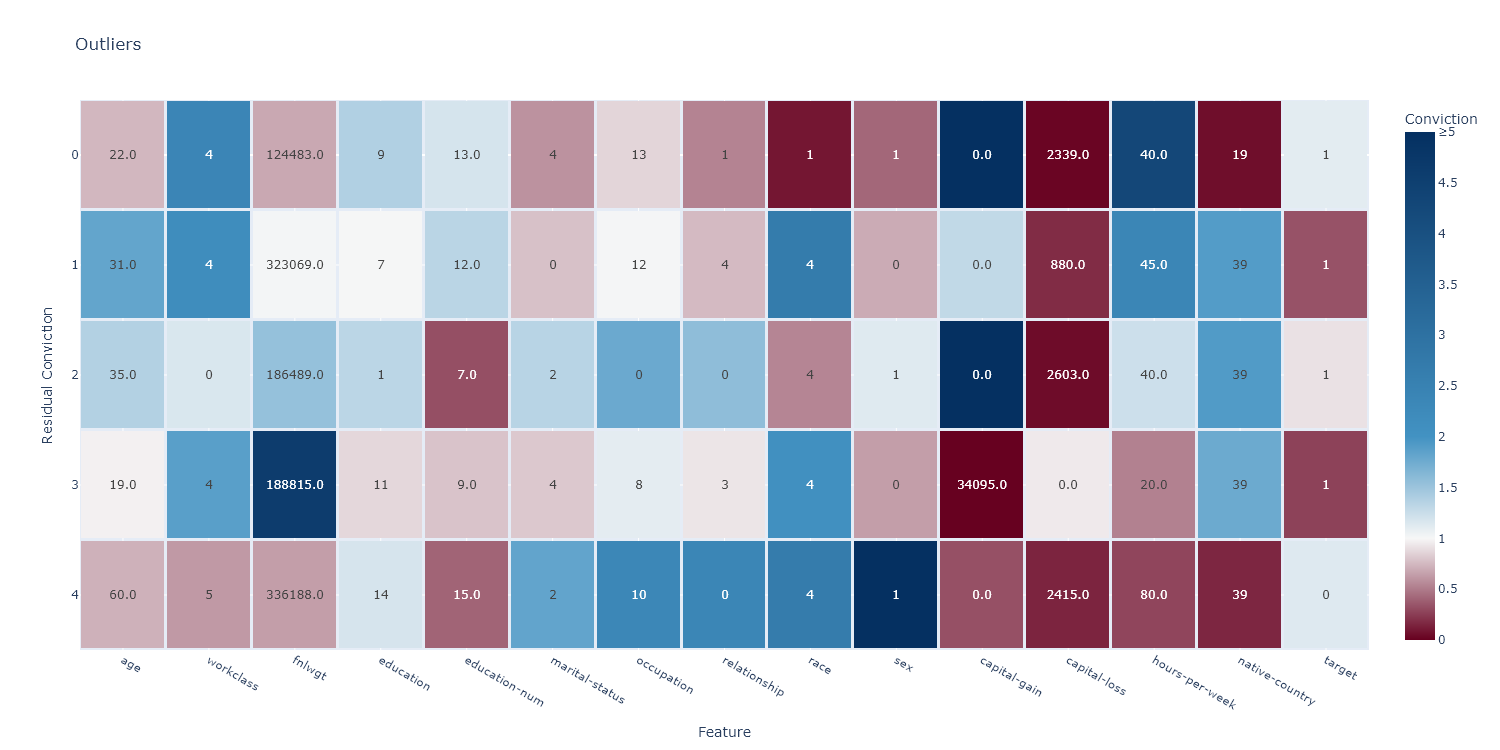

In [13]:
fig = plot_anomalies(outliers, case_feature_residual_convictions, title="Outliers", yaxis_title="Residual Conviction")
fig.update_layout(width=1500, height=750)

The heat map explains the reason why each case was an outlier. The darker the shade of red, the more surprising the feature value is, which contributes to the case's status as an outlier.

## Step 3: Inspect Inliers

Let’s examine a few inlier cases. Inliers are cases which are too similar to other cases and do not follow the expected distribution. Inliers can be an indication of a fraudulent case that is “too good to be true”. 

In [14]:
# Get the inlier cases
inliers = low_convicts[low_convicts['category'] == 'inlier'].reset_index(drop=True)
inliers

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,category
0,35.0,4,209629.0,9,13.0,4,10,1,4,1,0.0,0.0,40.0,39,1,0.162348,719,5c430afe-9f5f-477a-b3dc-327fc000553d,0.187867,inlier
1,35.0,4,184655.0,9,13.0,4,10,1,4,1,0.0,0.0,40.0,39,1,0.162659,409,5c430afe-9f5f-477a-b3dc-327fc000553d,0.191502,inlier
2,28.0,4,282389.0,11,9.0,4,14,1,4,1,0.0,0.0,60.0,39,1,0.170279,21,5c430afe-9f5f-477a-b3dc-327fc000553d,0.234354,inlier
3,37.0,2,249392.0,8,11.0,2,11,0,4,1,0.0,0.0,40.0,39,0,0.172792,127,5c430afe-9f5f-477a-b3dc-327fc000553d,0.341692,inlier
4,30.0,4,303990.0,11,9.0,4,14,1,4,1,0.0,0.0,60.0,39,1,0.173249,50,5c430afe-9f5f-477a-b3dc-327fc000553d,0.229681,inlier
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,33.0,4,292465.0,6,5.0,2,7,0,4,1,0.0,0.0,50.0,39,1,0.483063,572,5c430afe-9f5f-477a-b3dc-327fc000553d,2.261926,inlier
96,43.0,4,145762.0,9,13.0,2,4,0,4,1,0.0,0.0,40.0,39,1,0.486786,442,5c430afe-9f5f-477a-b3dc-327fc000553d,2.108072,inlier
97,20.0,4,362999.0,15,10.0,4,1,3,4,0,0.0,0.0,20.0,39,1,0.491418,338,5c430afe-9f5f-477a-b3dc-327fc000553d,1.256321,inlier
98,50.0,0,260579.0,11,9.0,2,0,0,2,1,0.0,0.0,40.0,39,1,0.495731,962,5c430afe-9f5f-477a-b3dc-327fc000553d,4.864435,inlier


Similarly to what we did with the outliers, we will use the Feature Residual Convictions to understand what feature values are unusual. In this case, we may expect to see many feature values with very high convictions, indicating that the feature value is particularly unsurprising.

In [15]:
# Specify the inlier cases
inliers_indices = inliers[['.session', '.session_training_index']].values

# React to get the details of each case
results = t.react(case_indices=inliers_indices,
                  preserve_feature_values=df.columns.tolist(),
                  leave_case_out=True,
                  details=details)

In [16]:
# Extract the case feature residual convictions
case_feature_residual_convictions = pd.DataFrame(results['details']['feature_robust_residual_convictions_for_case'])[df.columns.tolist()]

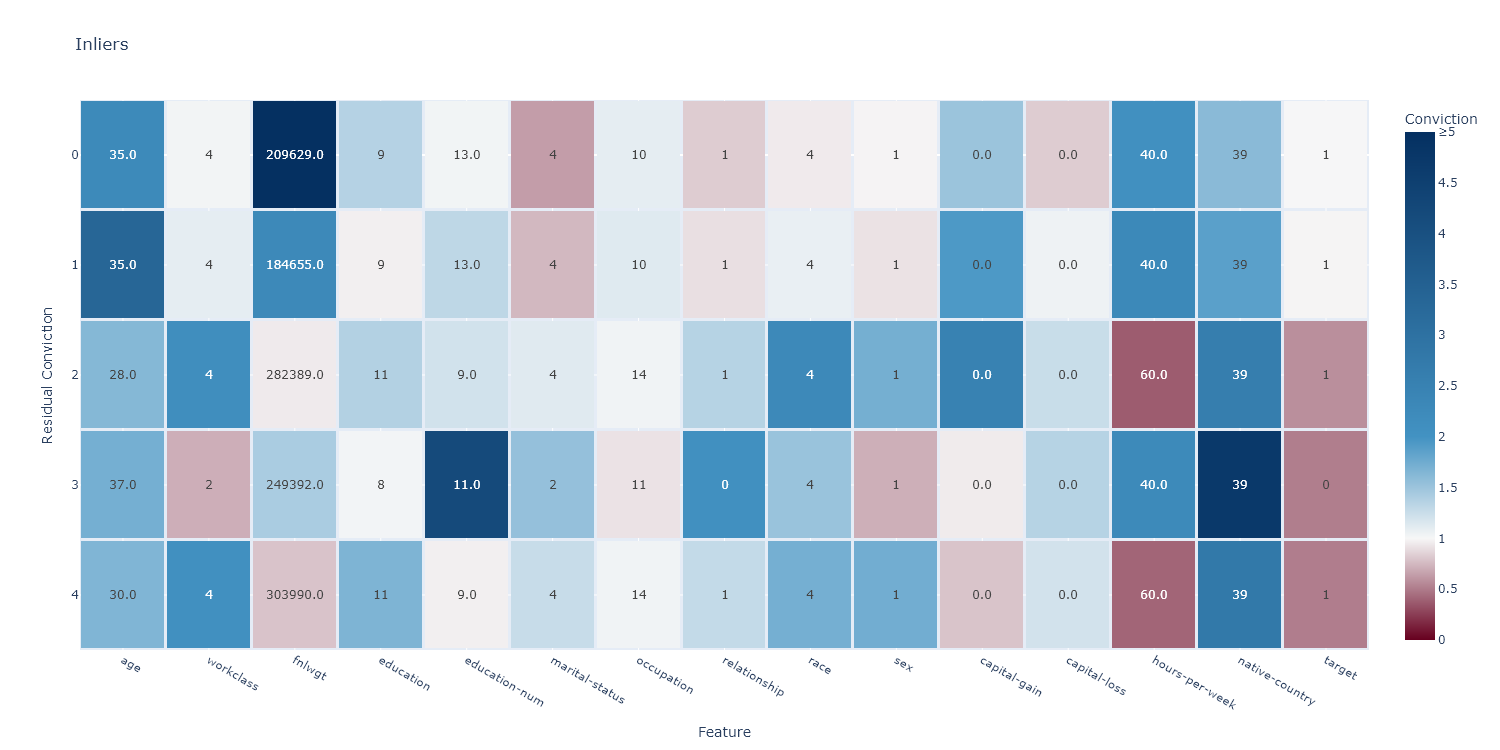

In [17]:
fig = plot_anomalies(inliers, case_feature_residual_convictions, title="Inliers", yaxis_title="Residual Conviction")
fig.update_layout(width=1500, height=750)

The heat map explains the reason why each case was an inlier. The more unspurprising the value is. If this seems unintuitive, imagine a dataset where values are always hard to predict with an error of less than 15.0. If a case were to suddenly appear where every value was predicted perfectly, its Feature Residual Conviction values would all be extremely high (dark blue in the case of this visualization).

# Section 4: Finding Potential Improvements in the Dataset

Sparse regions of the model or under defined problems can make it difficult to make an accurate prediction. Howso Engine can be used to identify potential data, or model improvements by examining the residual conviction and density.

## Step 1: Compute Case Feature Residual Convictions

Case Feature Residual Convicion is a ratio of the local residual for each feature to the case residual. Inspecting these conviction values helps users understand what regions of their data are easier or more difficult to predict compared to the average across the dataset.

Understanding this can help users understand where more data collection may be beneficial.

In [18]:
# Identify cases for investigation
partial_train_df = stored_convictions
partial_train_cases = partial_train_df[['.session', '.session_training_index']]

In [19]:
# Residual convictions are output via the case_feature_residual_convictions explanation
details = {
    'feature_robust_residual_convictions_for_case':True,
    'features': ['target'],
}

# Get the residual convictions for the specified cases
new_result = t.react(case_indices=partial_train_cases.values.tolist(),
                     leave_case_out=True,
                     preserve_feature_values=df.drop(action_features, axis=1).columns.tolist(),
                     action_features=action_features,
                     details=details)

In [20]:
# Extract residual conviction
target_residual_convictions = [ x['target'] for x in new_result['details']['feature_robust_residual_convictions_for_case'] ]

# Binarize residual conviction
convict_threshold = 0.50
low_residual_conviction = [1 if x <= convict_threshold else 0 for x in target_residual_convictions]

# Density is just the inverse of distance_contribution
density = 1 / partial_train_df['distance_contribution']

# Add new features to the dataframe
partial_train_df['density'] = density
partial_train_df['target_residual_conviction'] = target_residual_convictions
partial_train_df['low_residual_conviction'] = low_residual_conviction

In [21]:
partial_train_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,...,hours-per-week,native-country,target,familiarity_conviction_addition,.session_training_index,.session,distance_contribution,density,target_residual_conviction,low_residual_conviction
0,33.0,4,191930.0,11,9.0,4,8,2,2,1,...,50.0,39,1,2.358593,0,5c430afe-9f5f-477a-b3dc-327fc000553d,5.338776,0.187309,1.765926,0
1,54.0,6,164757.0,8,11.0,2,3,0,4,1,...,16.0,39,1,47.549545,1,5c430afe-9f5f-477a-b3dc-327fc000553d,10.887711,0.091847,0.982259,0
2,46.0,2,14878.0,14,15.0,2,10,0,1,1,...,40.0,30,0,0.492163,2,5c430afe-9f5f-477a-b3dc-327fc000553d,48.883560,0.020457,0.947776,0
3,34.0,4,46492.0,11,9.0,2,3,0,4,1,...,50.0,39,0,0.514951,3,5c430afe-9f5f-477a-b3dc-327fc000553d,1.508737,0.662806,0.513466,0
4,65.0,6,111483.0,15,10.0,2,4,0,4,1,...,10.0,39,0,0.406447,4,5c430afe-9f5f-477a-b3dc-327fc000553d,40.461772,0.024715,0.620844,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,33.0,4,157887.0,6,5.0,2,7,0,4,1,...,50.0,39,1,0.430000,995,5c430afe-9f5f-477a-b3dc-327fc000553d,2.264959,0.441509,1.191615,0
996,20.0,4,38001.0,15,10.0,4,8,3,4,0,...,20.0,39,1,0.470838,996,5c430afe-9f5f-477a-b3dc-327fc000553d,1.162228,0.860416,2.202569,0
997,41.0,4,31221.0,11,9.0,0,8,4,4,0,...,30.0,39,1,1.020223,997,5c430afe-9f5f-477a-b3dc-327fc000553d,3.008712,0.332368,1.529458,0
998,57.0,4,296152.0,15,10.0,0,4,2,4,0,...,10.0,39,1,7.888693,998,5c430afe-9f5f-477a-b3dc-327fc000553d,19.305138,0.051800,1.079035,0


In [22]:
# Helper function to resize the data points
def get_sizes(min_size, max_size, series):
    min_value = series.min()
    max_value = series.max()

    m = (max_size - min_size) / (max_value - min_value)

    sizes = series * m + min_size
    return (sizes)

partial_train_df["density"] = get_sizes(5, 500, partial_train_df["density"])

With the Residual Convictions computed for the "target" feature across all the trained data, we can visualize the data to attempt to find the regions of the data where convictions are particularly low. 

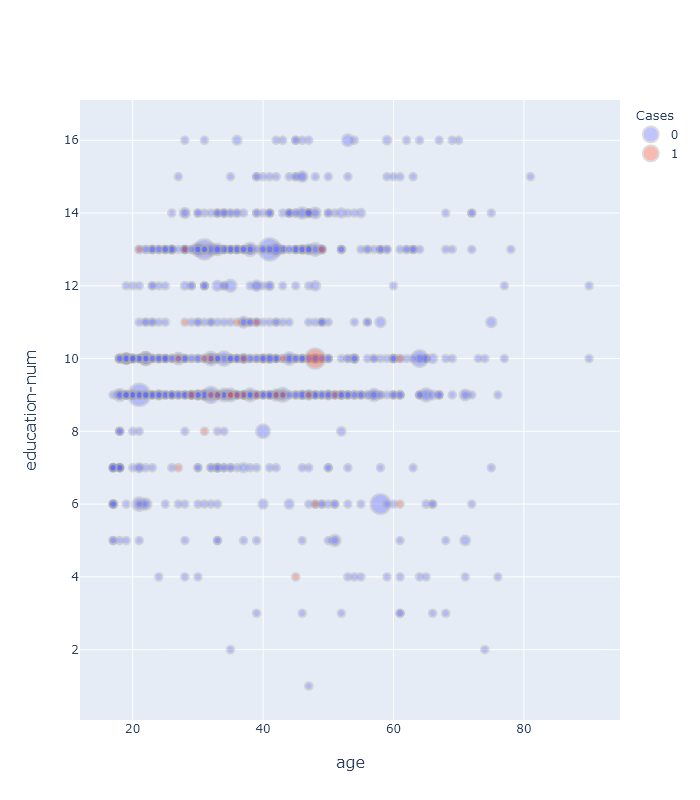

In [23]:
plot_dataset(partial_train_df, x="age", y="education-num", size="density", hue="low_residual_conviction", alpha=0.4)

The above graph is a visualization of the data set in 2-dimensions, with the color as an indication of residual conviction and the size representing the density of the data. More specifically, the orange color represents the low conviction points (points which are very uncertain), and small size represents low density. Therefore, adding more data to the region with small, orange points can improve model performance. 


On the other hand, an orange point that is large would be an indication that this case lies in an dense region but was not predictable. Hence, this will be an indication where the problem is not well defined, or the data is missing key features.  


# Conclusion

In this recipe, we demonstrate many of the metrics that the Trainee provides which helps users understand the model's decision making process such as feature MDA and feature residuals.

Additionally, we show how different types of conviction can be used to identify inliers, outliers, and regions of the data where increased data collection or feature engineering may be appropriate.